# B. Import Pustaka

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#preprocess
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Embedding, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# C. Data Load

### Import with Kaggle

In [2]:
#permission access kaggle to root
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [3]:
#kaggle on default folder
!mkdir ./kaggle
!mv ./kaggle.json /kaggle

In [4]:
#granting access permission
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#download dataset
!kaggle datasets download -d nicapotato/womens-ecommerce-clothing-reviews
!mkdir e-clothing_reviews
!unzip womens-ecommerce-clothing-reviews -d e-clothing_reviews

  0% 0.00/2.79M [00:00<?, ?B/s]
100% 2.79M/2.79M [00:00<00:00, 91.8MB/s]
Archive:  womens-ecommerce-clothing-reviews.zip
  inflating: e-clothing_reviews/Womens Clothing E-Commerce Reviews.csv  


### The Dataset

In [6]:
df = pd.read_csv('/content/e-clothing_reviews/Womens Clothing E-Commerce Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


EDA
- group by rating 3 ke bawah dan liat umur. 
- average age
- count values for every rating
- group by department name then seek for rating distribution from each department
- word cloud for every rating in general also on each department

In [7]:
#dataset dimension
df.shape

(23486, 11)

In [8]:
#dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [9]:
#basicly there are some null values. but we'll take a look deeper in this syntax
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [10]:
#looking for duplicated data
df.duplicated().value_counts()

False    23486
dtype: int64

# D. Data Cleaning (Missing Values)

# E. Exploratory Data Analysis

1. Bivariate Analysis
2. Multivariate Analysis
3. Word Cloud
4. Number of Target Amount

In [20]:
df.loc[df['Rating'] < 4,'sentiment'] = 'Negative'
df.loc[df['Rating'] > 3,'sentiment'] = 'Positive'

**Target Distribution**


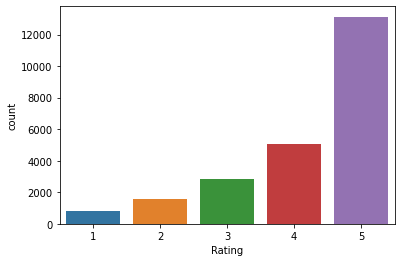

In [21]:
#visualize number counts of rating
sns.countplot(df['Rating'], data=df)

In [22]:
#exact counts from Rating Column
df['Rating'].value_counts()

5    13131
4     5077
3     2871
2     1565
1      842
Name: Rating, dtype: int64

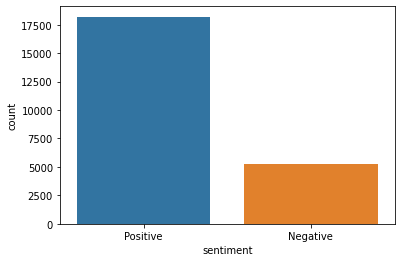

In [23]:
#target distribution based on sentiment
sns.countplot(df['sentiment'], data=df)

In [24]:
#exact counts from Rating Column
df['sentiment'].value_counts()

Positive    18208
Negative     5278
Name: sentiment, dtype: int64

# F. Data Pre-Processing

In [25]:
skip = df[['Review Text', 'Rating', 'sentiment']]
skip.dropna(inplace=True)
skip.head()

,Review Text,Rating,sentiment
0,Absolutely wonderful - silky and sexy and comf...,4,Positive
1,Love this dress! it's sooo pretty. i happene...,5,Positive
2,I had such high hopes for this dress and reall...,3,Negative
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Positive
4,This shirt is very flattering to all due to th...,5,Positive


In [26]:
skip.shape

(22641, 3)

### Case Folding

In [27]:
#prepare the function
def remove_digits(string):
    return re.sub(r'\d+', '', string)

def remove_punctuation(text):
    return text.translate(str.maketrans("","", string.punctuation))

def remove_strip(text):
    return text.strip()

#define for stopwords
stop = stopwords.words('english')

In [28]:
skip['sentiment'] = skip['sentiment'].str.lower() #lowercase
skip['Review Text'] = skip['Review Text'].str.lower() #lowercase
skip['Review Text'] = skip['Review Text'].apply(remove_digits) #remove numbers
skip['Review Text'] = skip['Review Text'].apply(remove_punctuation) #remove punctuation
skip['Review Text'] = skip['Review Text'].apply(remove_strip) #remove whitespaces

skip['Review Text'] = skip['Review Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [29]:
#clean part 2
def clean_text_round2(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [30]:
skip['Review Text'] = skip['Review Text'].apply(round2)

In [31]:
#clean part 3
def clean_text_round3(text):
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round3 = lambda x: clean_text_round3(x)

In [32]:
skip['Review Text'] = skip['Review Text'].apply(round3)

Dataset After Case Folding

In [62]:
skip.head()

,Review Text,Rating,sentiment
0,absolutely wonderful silky sexy comfortable,4,positive
1,love dress sooo pretty happened find store im glad bc never would ordered online bc petite bought petite love length hits little knee would definitely true midi someone truly petite,5,positive
2,high hopes dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layers imo major design flaw net layer sewn directly zipper c,3,negative
3,love love love jumpsuit fun flirty fabulous every time wear get nothing great compliments,5,positive
4,shirt flattering due adjustable front tie perfect length wear leggings sleeveless pairs well cardigan love shirt,5,positive


### Stemming & Lemmatization

In [54]:
import nltk
ps = nltk.stem.PorterStemmer()
snow = nltk.stem.SnowballStemmer('english')
lm = nltk.wordnet.WordNetLemmatizer()
nltk.download('wordnet')

df_stem1 = skip.copy() #dataset with portar stemmer
df_stem2 = skip.copy() #dataset with snowball stemmer
df_lemma = skip.copy() #dataset with lemma
df_both1 = skip.copy() #dataset with portar stem & lemma
df_both2 = skip.copy() #dataset with snowball stem & lemma

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
def port_stemmer(sentence):
    tokens = sentence.split()
    stemmed_tokens = [ps.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def port_stemmer(PorterStemmer):
    return ps.stem()
def snow_stemmer(text):
    return snow.stem()
def lemmatizer(text):
    return lm.lemmatize()

In [ ]:
#Porter Stemmer Sample Result
df_stem1['Review Text'] = df_stem1['Review Text'].apply(lambda x: [ps.stem(y) for y in x])
pd.set_option('display.max_colwidth', -1)
df_stem1.head()

In [ ]:
df_stem2['Review Text'] = df_stem2['Review Text'].apply(lambda x: [snow.stem(y) for y in x])
pd.set_option('display.max_colwidth', -1)
df_stem2.head()

In [ ]:
df_lemma['Review Text'] = df_lemma['Review Text'].apply(lambda x: [lm.lemmatize(y) for y in x])
pd.set_option('display.max_colwidth', -1)
df_lemma.head()

## Pre-Processing

`skip = dataset without stem & lemma`

`df_stem = dataset with stem`

`df_lemma = dataset with lemma`

`df_both = dataset with stem & lemma`

In [67]:
skip['sentiment'] = skip['sentiment'].replace({'negative':  0, 'positive': 1})

In [68]:
X = skip['Review Text']
y = skip['sentiment']

#first split into X_train and X_remaining 75:25
X_train, X_rem, y_train, y_rem = train_test_split(X.to_numpy(), y, stratify = y, train_size=0.75)

#second split. from X_remain to X_val+X_test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

#numbers
print("Input Training:", X_train.shape), print("Output Training:", y_train.shape)
print("Input Val:", X_val.shape), print("Output Val:", y_val.shape)
print("Input Test:", X_test.shape), print("Output Test:", y_test.shape)

Input Training: (16980,)
Output Training: (16980,)
Input Val: (2830,)
Output Val: (2830,)
Input Test: (2831,)
Output Test: (2831,)


(None, None)

In [69]:
X_train[:6], y_train[:6]

(array(['searching denim trucker jacket since last fall happy see retailer stock purchased online without thinking twice typically due small upper frame im lbs referance im size small xs bought opted size small arrived love fit slightly cropped back also like lined inside great quality perfect fall',
        'looking sweater online since first came finally ordered ordered size petite sadly arrived tried boxy stiff like flow like looked model online sent back',
        'love style dress length hem waist details material think looks best curvy women due waist detail going part way around doesnt give entire waist definition would look best someone naturally defined waist pretty unique dress one reasons liked agree one previous reviewers hard conceal bra straps unfortunately deal breaker rea',
        'loved jacket looked online decided order however sizing sometimes tricky ordered petite xs petite xxs im lb bra size c tired xxs first swimming naturally thought xs would even bigger surpris

### Token Layer & Embed Layer

In [70]:
#numbers for max_length
num_length = round(sum([len(i.split()) for i in X_train])/len(X_train))
num_length

29

In [77]:
# setup text vect
#if we set max vocab to 100.000, max amount number of vocab will be 15574, so we'll be set only at 15000 vocab
max_vocab_length = 15000
max_length = num_length

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)
text_vectorization.adapt(X_train)

In [79]:
output_dim = 64

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=output_dim,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             mask_zero=True)

In [ ]:
layers.GlobalAveragePooling1D(keepdims=True)

# G. Model Definition

In [92]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [93]:
#definition
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
output = Dense(1, activation="sigmoid")(x)
base_model = tf.keras.Model(inputs, output, name="base_model")

#compile
base_model.compile(loss='binary_crossentropy', 
                   optimizer='adam',
                   metrics=["accuracy"])

In [94]:
#base model architecture
base_model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 29)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 29, 64)            960000    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 960,065
Trainable params: 960,065
Non-trai

# H. Model Training

In [95]:
base_history = base_model.fit(X_train, y_train, epochs=20, 
                                 validation_data=(X_val, y_val))

Epoch 1/20
531/531 [==============================] - 10s 16ms/step - loss: 0.4545 - accuracy: 0.7890 - val_loss: 0.3469 - val_accuracy: 0.8382
Epoch 2/20
531/531 [==============================] - 7s 14ms/step - loss: 0.2926 - accuracy: 0.8767 - val_loss: 0.2961 - val_accuracy: 0.8682
Epoch 3/20
531/531 [==============================] - 7s 14ms/step - loss: 0.2468 - accuracy: 0.9001 - val_loss: 0.2918 - val_accuracy: 0.8767
Epoch 4/20
531/531 [==============================] - 8s 14ms/step - loss: 0.2204 - accuracy: 0.9127 - val_loss: 0.2969 - val_accuracy: 0.8746
Epoch 5/20
531/531 [==============================] - 8s 15ms/step - loss: 0.2007 - accuracy: 0.9231 - val_loss: 0.3032 - val_accuracy: 0.8739
Epoch 6/20
531/531 [==============================] - 8s 15ms/step - loss: 0.1839 - accuracy: 0.9310 - val_loss: 0.3132 - val_accuracy: 0.8742
Epoch 7/20
531/531 [==============================] - 8s 15ms/step - loss: 0.1699 - accuracy: 0.9370 - val_loss: 0.3250 - val_accuracy: 0.868

In [96]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

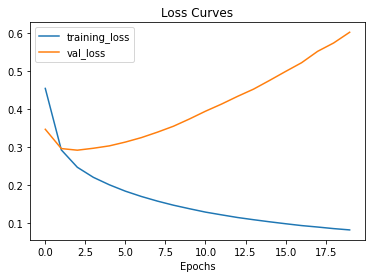

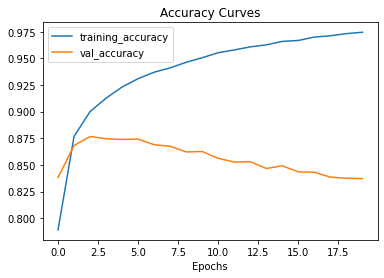

In [97]:
plot_loss_curves(base_history)

In [99]:
#classification report
from sklearn.metrics import classification_report

thre = 0.5
res = base_model.predict(X_val)
res = (res > thre).T
res = res.astype(int)[0]

print(classification_report(y_val, res))

              precision    recall  f1-score   support

           0       0.66      0.60      0.63       655
           1       0.88      0.91      0.90      2175

    accuracy                           0.84      2830
   macro avg       0.77      0.75      0.76      2830
weighted avg       0.83      0.84      0.83      2830



# I. Model Improvement

### SMOTE

In [117]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

### Count Vectorizer

In [102]:
# Create the word vector with CountVectorizer

count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [103]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 15553


In [104]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [105]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,aa,aaaaaaamazing,aaaaandidontwanttopayforshipping,aaaaannnnnnd,aaaahmazing,aaahed,aame,ab,abbey,abby,abdomen,abdominal,abercrombie,abhor,ability,abject,able,abnormal,abnormally,abo,abolutely,abou,abovetheknee,abovetheshoulders,abroad,abruptly,abs,absence,absolute,absolutely,absolutley,absolutly,absoluty,absorbent,abstract,absurd,abt,abundance,abused,abut,...,youve,yr,yrs,yuck,yucky,yuk,yumi,yummy,yup,zag,zara,zed,zermatt,zero,zeros,zig,zigzag,zigzagging,zillion,zip,zipbutton,zipepr,ziphoodie,ziploc,zipped,zipper,zippered,zipperi,zipperone,zippers,zippie,zipping,zips,zombie,zone,zoolanders,zoom,zooming,zuma,ã¼ber
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Model with Count Vectorizer

In [116]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(count_vect_train, y_train)
y_pred = model.predict(count_vect_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       643
           1       0.92      0.93      0.92      2188

    accuracy                           0.88      2831
   macro avg       0.83      0.82      0.83      2831
weighted avg       0.88      0.88      0.88      2831



### Tfid Vectorizer

In [108]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

In [109]:
# Print vocabulary length
print('Vocabulary length :', len(tfidf_vect.get_feature_names()))

Vocabulary length : 15553


In [111]:
# Assign feature names of vector into a variable
vocab = tfidf_vect.get_feature_names()

In [112]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(tfidf_vect_train, columns = vocab).head()

,aa,aaaaaaamazing,aaaaandidontwanttopayforshipping,aaaaannnnnnd,aaaahmazing,aaahed,aame,ab,abbey,abby,abdomen,abdominal,abercrombie,abhor,ability,abject,able,abnormal,abnormally,abo,abolutely,abou,abovetheknee,abovetheshoulders,abroad,abruptly,abs,absence,absolute,absolutely,absolutley,absolutly,absoluty,absorbent,abstract,absurd,abt,abundance,abused,abut,...,youve,yr,yrs,yuck,yucky,yuk,yumi,yummy,yup,zag,zara,zed,zermatt,zero,zeros,zig,zigzag,zigzagging,zillion,zip,zipbutton,zipepr,ziphoodie,ziploc,zipped,zipper,zippered,zipperi,zipperone,zippers,zippie,zipping,zips,zombie,zone,zoolanders,zoom,zooming,zuma,ã¼ber
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model with Tfid Vectorizer

In [115]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(tfidf_vect_train, y_train)
y_pred = model.predict(tfidf_vect_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.07      0.13       643
           1       0.78      1.00      0.88      2188

    accuracy                           0.79      2831
   macro avg       0.87      0.53      0.50      2831
weighted avg       0.82      0.79      0.71      2831

